# MLND CAPSTONE PROJECT - PREDICTING ELT RUN TIME

This notebook contains the code for the Udacity MLND capstone project for Blake Ward.

Project objectives:
1. Build a model to predict the total run time for a data ELT job based on given inputs

Steps:
1. Load Raw Data
2. Exploratory Analysis
3. Model Investigation
4. Model Tuning
5. Final Model

In [2]:
#Import the necessary libraries and packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
#Standard error calculation
def st_err(y_true, y_pred):
    squared_sum = np.sum(np.square(np.subtract(y_true,y_pred)))
    ste = np.sqrt(squared_sum/(len(y_true)*1.0))
    return ste
    

## LOAD RAW DATA

This data comes from an operational MySQL database that can only be accessed behind the company firewall.  For this reason the data can be loaded in two methods.

**Option 1**: Load the data from a stored csv (CSV will get recreated every time the query from option 2 is run)  
**Option 2**: Run the DB connection cell below and load based on a query

In [4]:
cols = ('source', 'dbType', 'source_type', 'jobType', 'run_time', 'total_objects_count', 'avg_object_run_time',
        'avg_run_time', 'max_run_time', 'min_run_time', 'std_run_time', 'avg_table_run_time', 
        'max_table_run_time', 'min_table_run_time')

features = ['source', 'jobType', 'dbType', 'source_type', 'total_objects_count', 'avg_object_run_time', 'avg_run_time', 'max_run_time', 'min_run_time', 'std_run_time', 'avg_table_run_time', 'min_table_run_time', 'max_table_run_time']
num_features = ['total_objects_count', 'avg_object_run_time', 'avg_run_time', 'max_run_time', 'min_run_time', 'std_run_time', 'avg_table_run_time', 'min_table_run_time', 'max_table_run_time']
cat_features = ['source',  'jobType', 'dbType', 'source_type']

target = ['run_time']

### DB Load Option

In [ ]:
"""
import mysql.connector

dbconfig = {
  'user': '',
  'password': '',
  'host': '',
  'port': '',  
  'database': '',
  'raise_on_warnings': True,
    }

query = ("""
    SELECT
        jm.source_system_name_rpt as `source`
        ,jm.source_system_type as dbType
        ,jm.source_type
        ,case when js.start_status = 'RS' then 'raw'
               when js.start_status = 'HS' then 'hive'
               when js.start_status = 'CS' then 'cdc' end as jobType
        ,js.run_time
        ,js.total_objects_count
        ,js.avg_object_run_time
        ,rt.avg_run_time
        ,rt.max_run_time
        ,rt.min_run_time
        ,rt.std_run_time
        ,rto.avg_table_run_time
        ,rto.max_table_run_time
        ,rto.min_table_run_time
    FROM
        dl_ingst_job_master jm
        INNER JOIN dl_ingst_job_stats js on jm.j_job_id = js.j_job_id
        LEFT JOIN dl_ingst_run_time rt on rt.j_job_id = js.j_job_id
                                    and rt.run_type = case when js.start_status = 'RS' then 'raw'
                                                        when js.start_status = 'HS' then 'hive'
                                                        when js.start_status = 'CS' then 'cdc' end
                                    and rt.object_type = 'job'
        LEFT JOIN (SELECT avg(avg_run_time) as avg_table_run_time, max(avg_run_time) as max_table_run_time, min(avg_run_time) as min_table_run_time, j_job_id, run_type
                    FROM dl_ingst_run_time WHERE object_type = 'table'
                    GROUP BY j_job_id, run_type) rto on rto.j_job_Id = js.j_job_id 
                                    and rto.run_type = case when js.start_status = 'RS' then 'raw'
                                                        when js.start_status = 'HS' then 'hive'
                                                        when js.start_status = 'CS' then 'cdc' end
    WHERE 
        instr(js.end_status,'F') = 0
        and rt.avg_run_time is not null
        and js.avg_object_run_time is not null
        and js.avg_object_run_time < js.run_time 
        """ 
    )

#test_query = "SELECT * FROM dl_ingst_job_master LIMIT 10"

cnx = mysql.connector.connect(**dbconfig)

cursor = cnx.cursor()

cursor.execute(query)

#cursor.execute("SELECT * FROM dl_ingst_job_master LIMIT 10")

rows = cursor.fetchall()

data = pd.DataFrame(rows,columns=cols)

data.to_csv('run-time-data.csv', sep=',', header=cols)

cursor.close()

cnx.close()
"""

### CSV Load Option

In [6]:
#Load the data from a flat file if DB connection not available

data = pd.read_csv('run-time-data.csv', sep=',', skipinitialspace=True, header=0, names=cols)


## EXPLORATORY DATA ANALYSIS


In [7]:
#Count nulls
print data.isnull().sum()

#Data types
print data.dtypes

# Print a few rows to examine
print data[0:5]


source                 0
dbType                 0
source_type            0
jobType                0
run_time               0
total_objects_count    0
avg_object_run_time    0
avg_run_time           0
max_run_time           0
min_run_time           0
std_run_time           0
avg_table_run_time     0
max_table_run_time     0
min_table_run_time     0
dtype: int64
source                  object
dbType                  object
source_type             object
jobType                 object
run_time                 int64
total_objects_count      int64
avg_object_run_time    float64
avg_run_time           float64
max_run_time           float64
min_run_time           float64
std_run_time           float64
avg_table_run_time     float64
max_table_run_time     float64
min_table_run_time     float64
dtype: object
              source  dbType source_type jobType  run_time  \
0           FX Rates  oracle          db     raw      2581   
1           FX Rates  oracle          db    hive        42   
2  

In [8]:
#Let's look at some summary statistics overall
print data.describe(include='all')

           source dbType source_type jobType       run_time  \
count       22018  22018       22018   22018   22018.000000   
unique        112     13           4       3            NaN   
top     SAP PS NA    sap          db     raw            NaN   
freq         6660   8945       20419    9880            NaN   
mean          NaN    NaN         NaN     NaN    2151.275456   
std           NaN    NaN         NaN     NaN    6538.921351   
min           NaN    NaN         NaN     NaN       1.000000   
25%           NaN    NaN         NaN     NaN     154.000000   
50%           NaN    NaN         NaN     NaN     437.000000   
75%           NaN    NaN         NaN     NaN    1757.750000   
max           NaN    NaN         NaN     NaN  196536.000000   

        total_objects_count  avg_object_run_time   avg_run_time  \
count          22018.000000         22018.000000   22018.000000   
unique                  NaN                  NaN            NaN   
top                     NaN               

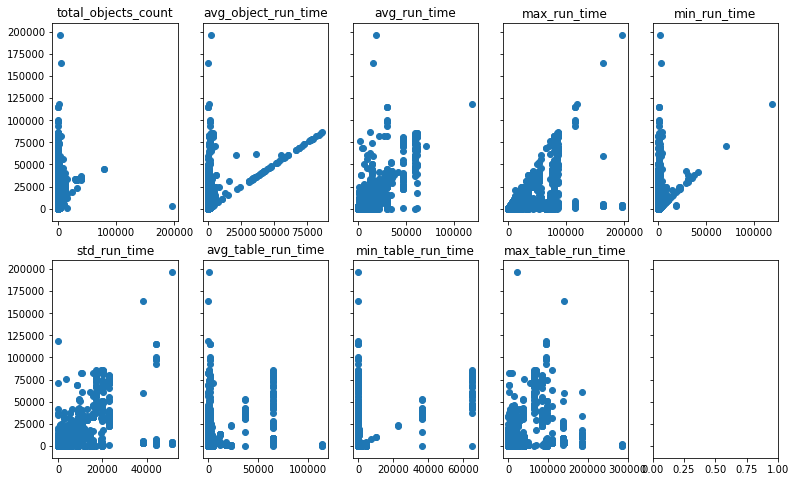

In [9]:
#Complete data visualization by run time

fig3, axes3 = plt.subplots(nrows = 2, ncols = 5, sharey=True, figsize = (13,8))

for i in range(len(num_features)):
    f = num_features[i]
    x = data[f]
    y = data[target]
    axes3[i/5,i%5].scatter(x.values, y)
    axes3[i/5,i%5].set_title(f)
plt.show()

cdc
           run_time  total_objects_count  avg_object_run_time  avg_run_time  \
count   2369.000000          2369.000000          2369.000000   2369.000000   
mean    2968.030393           123.790207           452.047389   2412.492883   
std     4227.287610          4054.224067           595.448063   1385.580877   
min       41.000000             1.000000            26.000000    139.126126   
25%      508.000000            14.000000           138.900000   2161.922131   
50%     1818.000000            16.000000           279.846200   2161.922131   
75%     2693.000000            47.000000           538.133300   3226.277228   
max    75935.000000        196470.000000          4813.526300   6458.510490   

       max_run_time  min_run_time  std_run_time  avg_table_run_time  \
count   2369.000000   2369.000000   2369.000000         2369.000000   
mean   29626.909667     36.088645   2839.374548         4363.309685   
std    29387.384072    128.944489   1843.672390        12364.926972   


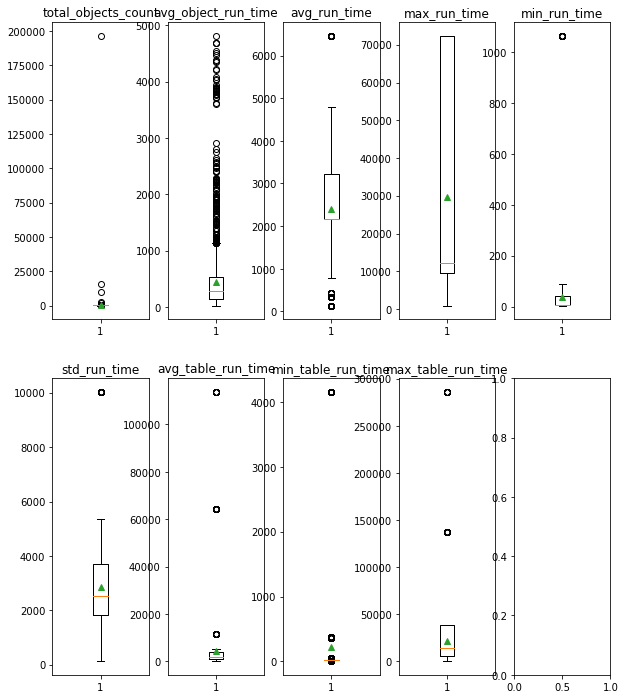

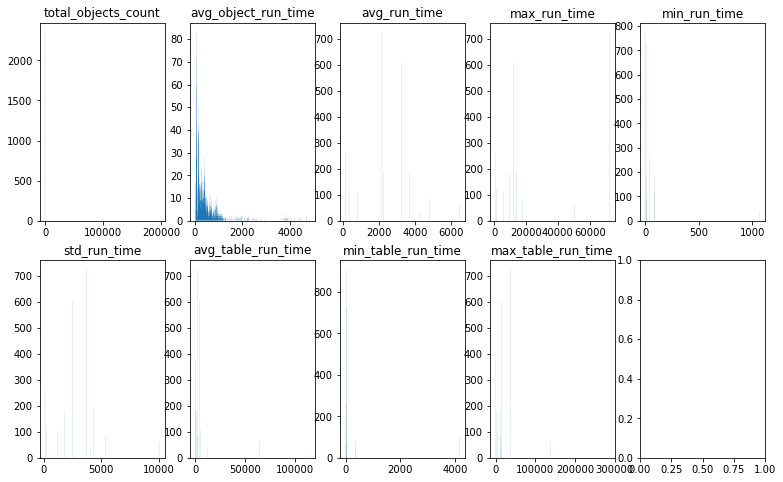

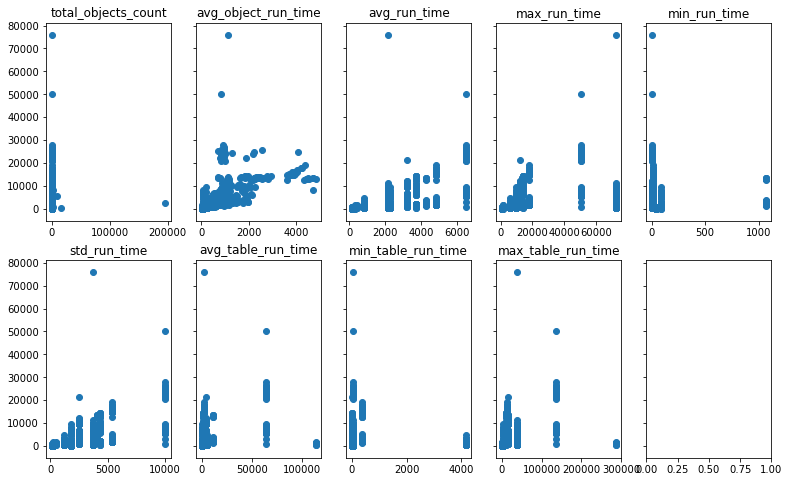

hive
           run_time  total_objects_count  avg_object_run_time  avg_run_time  \
count   9769.000000          9769.000000          9769.000000   9769.000000   
mean     485.851878            42.251305            66.717991    490.501251   
std     1176.659310            95.543335           195.094507    815.010982   
min       10.000000             1.000000             7.000000     20.166667   
25%      120.000000             4.000000            28.168200    189.057504   
50%      230.000000            23.000000            35.000000    312.307407   
75%      470.000000            49.000000            48.652200    601.529820   
max    25002.000000          2596.000000          7570.000000  20634.000000   

       max_run_time  min_run_time  std_run_time  avg_table_run_time  \
count   9769.000000   9769.000000   9769.000000         9769.000000   
mean    4850.778278     76.837036    579.070018          159.891536   
std     7406.759620    265.103401    813.961002         1277.701369   

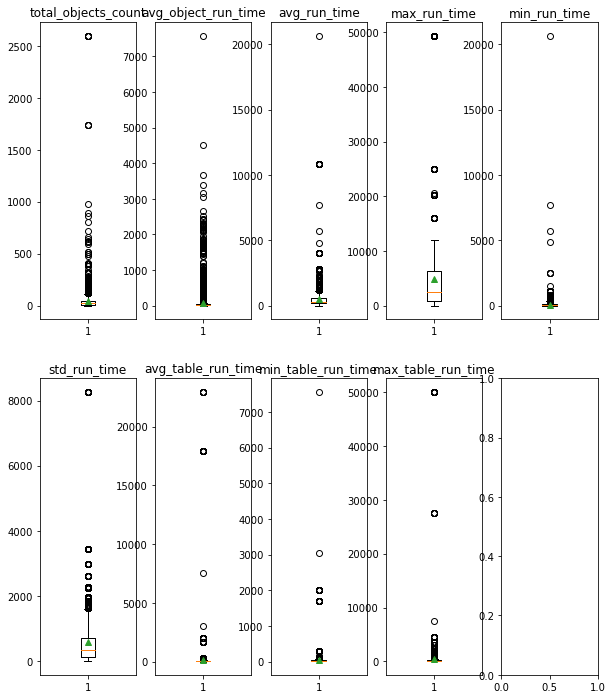

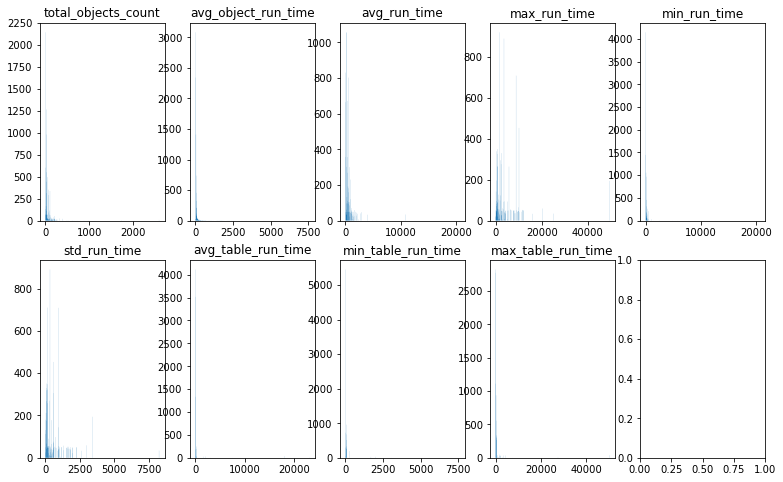

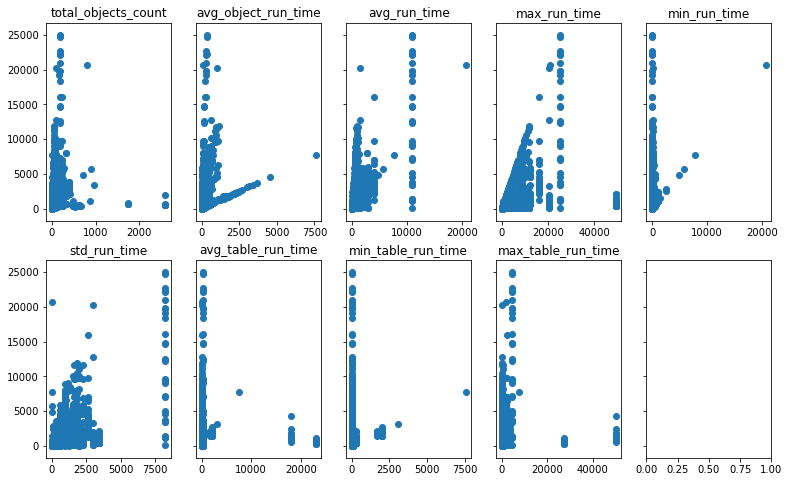

raw
            run_time  total_objects_count  avg_object_run_time   avg_run_time  \
count    9880.000000          9880.000000          9880.000000    9880.000000   
mean     3602.148988           521.386538           491.143143    3576.319506   
std      9199.556071          2279.185287          4363.524351    7431.265522   
min         1.000000             1.000000             0.000000       1.000000   
25%       281.000000            20.000000            27.875625     436.814867   
50%      1028.500000            37.000000            37.734950    1438.000000   
75%      2967.000000           370.000000            94.109000    3253.043478   
max    196536.000000         80084.000000         86308.000000  118904.000000   

        max_run_time   min_run_time  std_run_time  avg_table_run_time  \
count    9880.000000    9880.000000   9880.000000         9880.000000   
mean    13582.476518     524.794534   2100.228149          464.970774   
std     19221.389662    2080.049500   4406.8755

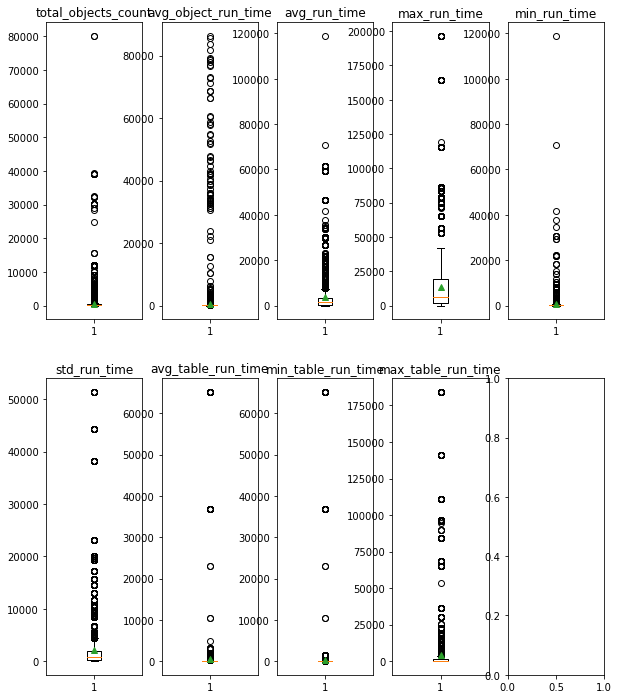

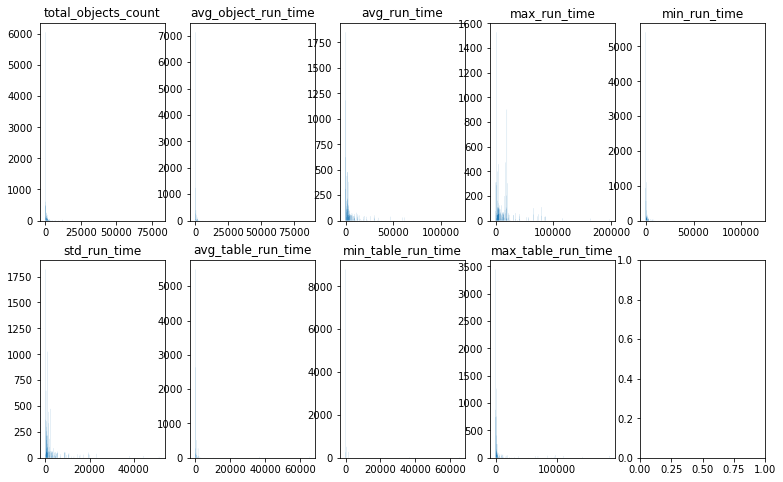

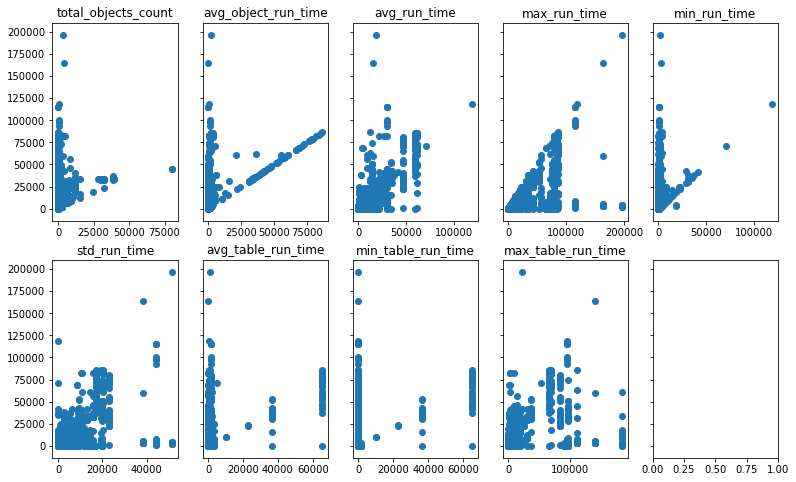

In [10]:
#Grouped descriptive data

#This data really  has three distinct types of jobs (jobType) so let's look at distrubtion by those types
for name, group in data.groupby('jobType'):
    print name
    print group.describe()
    fig, axes = plt.subplots(nrows = 2, ncols = 5, sharey=False, figsize = (10,12))
    fig2, axes2 = plt.subplots(nrows = 2, ncols = 5, sharey=False, figsize = (13,8))
    fig3, axes3 = plt.subplots(nrows = 2, ncols = 5, sharey=True, figsize = (13,8))
    for i in range(len(num_features)):
        f = num_features[i]
        print f
        x = group[f]
        y = group[target]
        axes[i/5,i%5].boxplot(x.values, showmeans=True)
        axes[i/5,i%5].set_title(f)
        axes2[i/5,i%5].hist(x.values, bins=1000, histtype='stepfilled')
        axes2[i/5,i%5].set_title(f)
        axes3[i/5,i%5].scatter(x.values, y)
        axes3[i/5,i%5].set_title(f)
    plt.show()



**Outliers:**
    
There are clearly some outliers in this data.  Although by nature these jobs will have a wide range of statistics, I know from experience with the jobs that there are some invalid numbers included in this set.  I am pulling our entire job history, but some of those runs have been early test runs and some of those runs have suffred from downed servers and technology glitches. These don't represent the true statistics of a run.  That said, I am going to be fairly cautions and only remove extreme outliers that are great than 10 standard deviations by job type (different job types have different distributions). These distributions aren't normal so this is my cautious approach. This isn't a large percentage of the population and will help me correct against known issues with some of the data. 

In [11]:
#Checking outliers based on descriptive stats above.  
#Doing outliers based on job type because these jobs have very different ranges.

outliers = set()

for name, group in data.groupby('jobType'):
    t = group[target][np.abs(group[target] - group[target].mean()) > group[target].mean() + 10*group[target].std()].dropna().index.tolist()
    for index in t:
        outliers.add(index)
    for i in range(len(num_features)):
        f = num_features[i]
        l = group[np.abs(group[f]-group[f].mean())>10*group[f].std()].index.tolist()
        for index in l:
            outliers.add(index)
            

print "Total outliers to be removed: " + str(len(outliers))

Total outliers to be removed: 279


In [12]:
#Review outliers
lo = list(outliers)


In [13]:
#Remove outliers
clean_data = data[~data.index.isin(lo)]

print "Data points in clean data: " + str(len(clean_data))

print clean_data[clean_data.total_objects_count > 70000]
print clean_data[clean_data.avg_object_run_time > 50000]


Data points in clean data: 21739
Empty DataFrame
Columns: [source, dbType, source_type, jobType, run_time, total_objects_count, avg_object_run_time, avg_run_time, max_run_time, min_run_time, std_run_time, avg_table_run_time, max_table_run_time, min_table_run_time]
Index: []
Empty DataFrame
Columns: [source, dbType, source_type, jobType, run_time, total_objects_count, avg_object_run_time, avg_run_time, max_run_time, min_run_time, std_run_time, avg_table_run_time, max_table_run_time, min_table_run_time]
Index: []


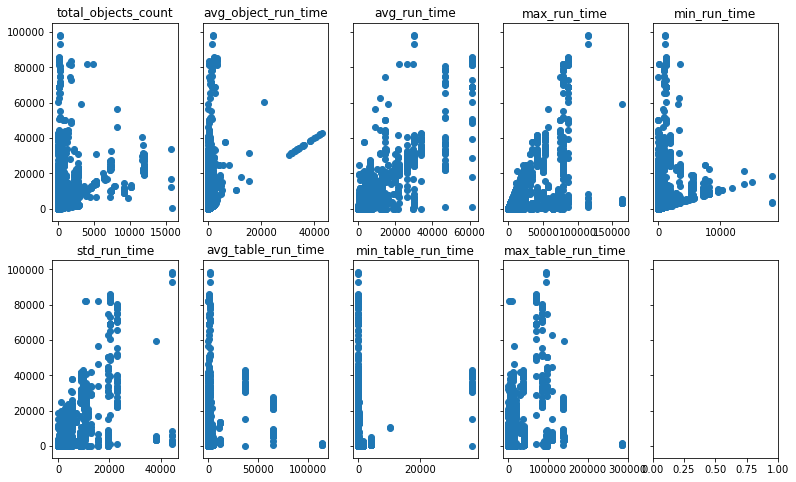

In [14]:
#Redo Complete data visualization by run time with clean_data

fig3, axes3 = plt.subplots(nrows = 2, ncols = 5, sharey=True, figsize = (13,8))

for i in range(len(num_features)):
    f = num_features[i]
    x = clean_data[f]
    y = clean_data[target]
    axes3[i/5,i%5].scatter(x.values, y)
    axes3[i/5,i%5].set_title(f)
plt.show()

cdc
           run_time  total_objects_count  avg_object_run_time  avg_run_time  \
count   2366.000000          2366.000000          2366.000000   2366.000000   
mean    2917.428571            40.881234           451.620886   2410.544772   
std     3833.169775           386.925936           595.617980   1383.848772   
min       41.000000             1.000000            26.000000    139.126126   
25%      507.250000            14.000000           138.787500   2161.922131   
50%     1814.500000            16.000000           279.615400   2161.922131   
75%     2692.000000            47.000000           538.013475   3226.277228   
max    27731.000000         15768.000000          4813.526300   6458.510490   

       max_run_time  min_run_time  std_run_time  avg_table_run_time  \
count   2366.000000   2366.000000   2366.000000         2366.000000   
mean   29607.531699     36.127219   2836.106124         4339.145662   
std    29387.632731    129.021687   1838.796301        12310.931058   


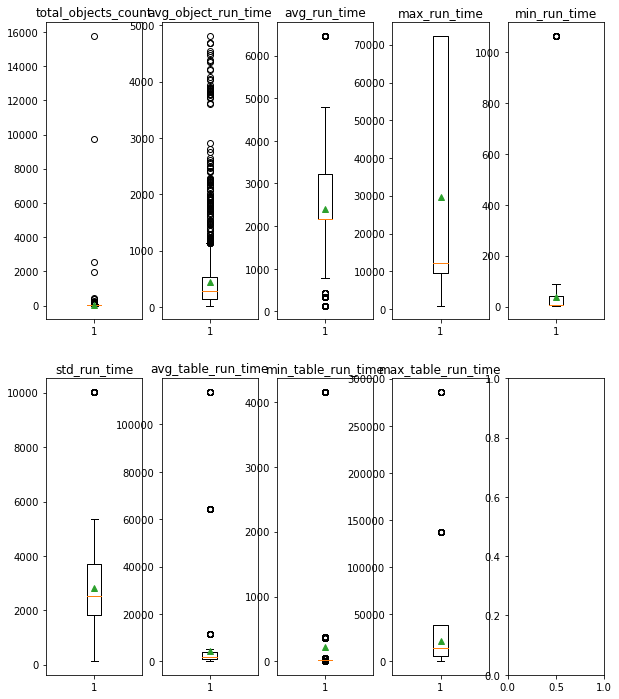

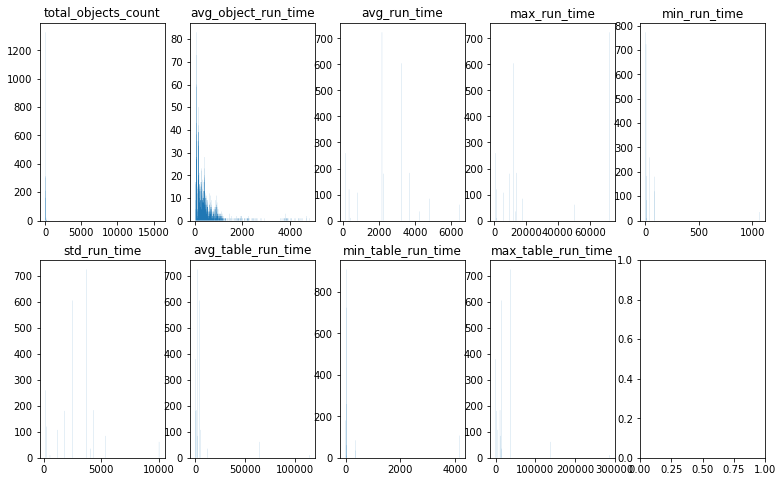

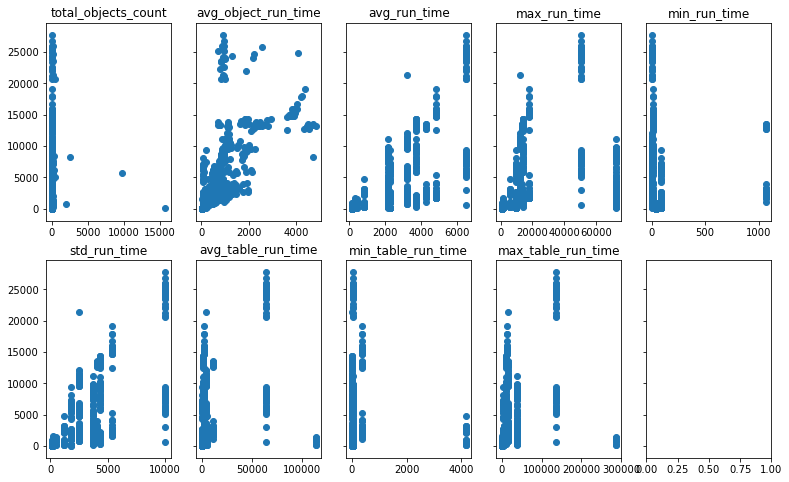

hive
           run_time  total_objects_count  avg_object_run_time  avg_run_time  \
count   9618.000000          9618.000000          9618.000000   9618.000000   
mean     429.583385            38.930131            52.970198    438.647164   
std      805.813222            53.176213            78.663202    473.191430   
min       10.000000             1.000000             7.000000     20.166667   
25%      118.000000             4.000000            28.108400    189.057504   
50%      225.000000            23.000000            34.750000    302.000000   
75%      458.000000            49.000000            47.537800    601.529820   
max    11937.000000           663.000000          1550.000000   4027.243243   

       max_run_time  min_run_time  std_run_time  avg_table_run_time  \
count   9618.000000   9618.000000   9618.000000         9618.000000   
mean    4792.403618     71.199834    551.374756           62.689801   
std     7357.593474    120.879824    678.768104           46.215628   

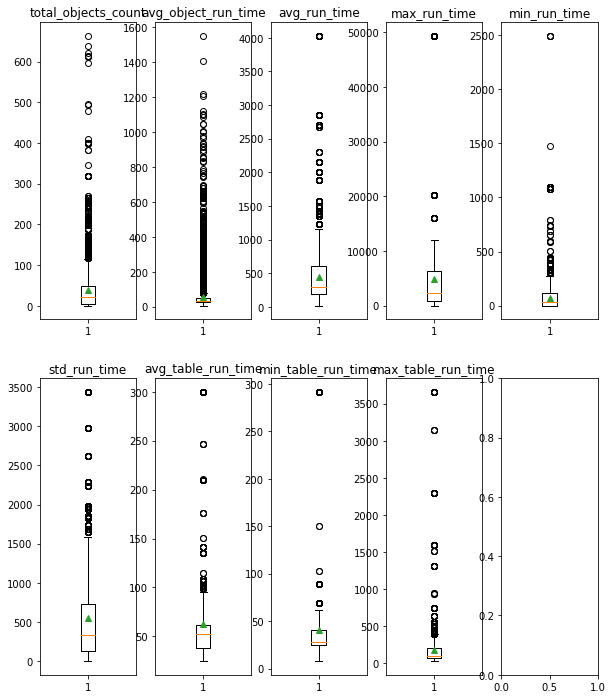

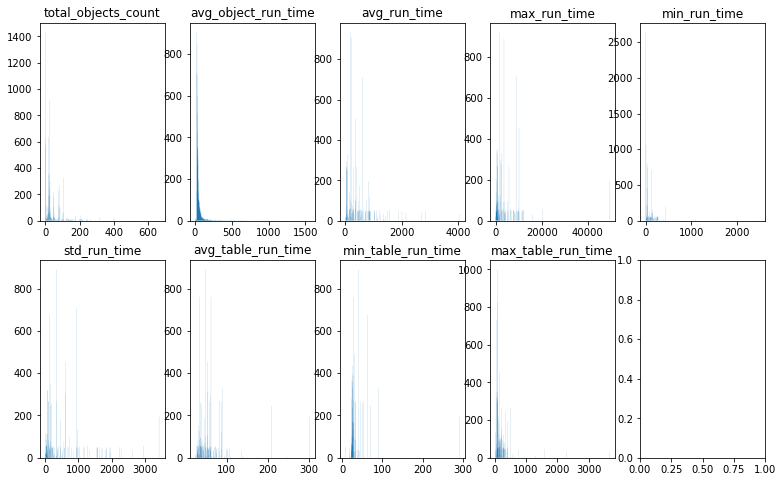

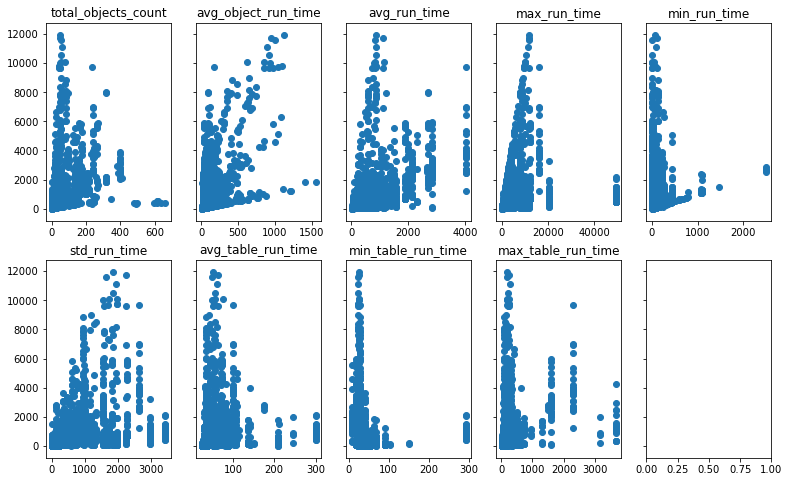

raw
           run_time  total_objects_count  avg_object_run_time  avg_run_time  \
count   9755.000000          9755.000000          9755.000000   9755.000000   
mean    3145.168529           432.574577           249.483162   3216.275797   
std     7382.271847          1229.367779          1894.986475   6364.413238   
min        1.000000             1.000000             0.000000      1.000000   
25%      278.000000            20.000000            27.830400    436.814867   
50%      964.000000            37.000000            37.352900   1429.245665   
75%     2878.500000           369.000000            92.657650   3224.836066   
max    98438.000000         15690.000000         42913.000000  61347.523810   

        max_run_time  min_run_time  std_run_time  avg_table_run_time  \
count    9755.000000   9755.000000   9755.000000         9755.000000   
mean    12699.730395    466.892158   1904.139458          247.866442   
std     17173.186660   1105.121031   3837.944247         1884.267334

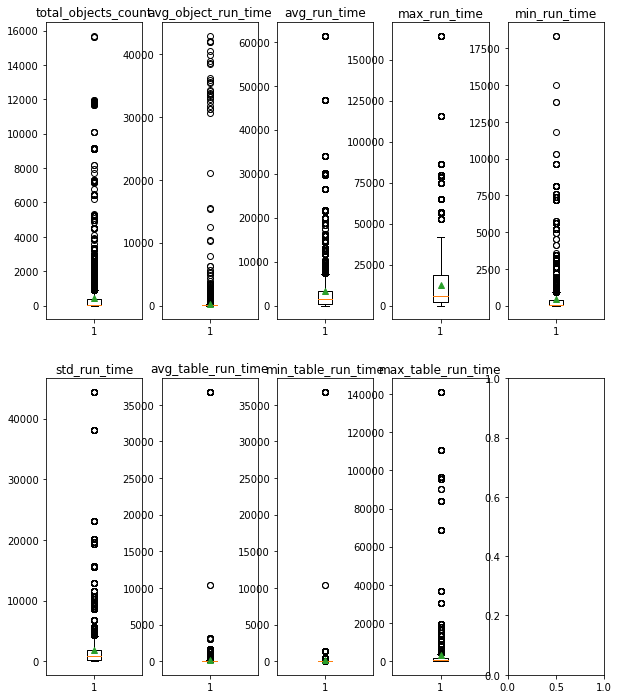

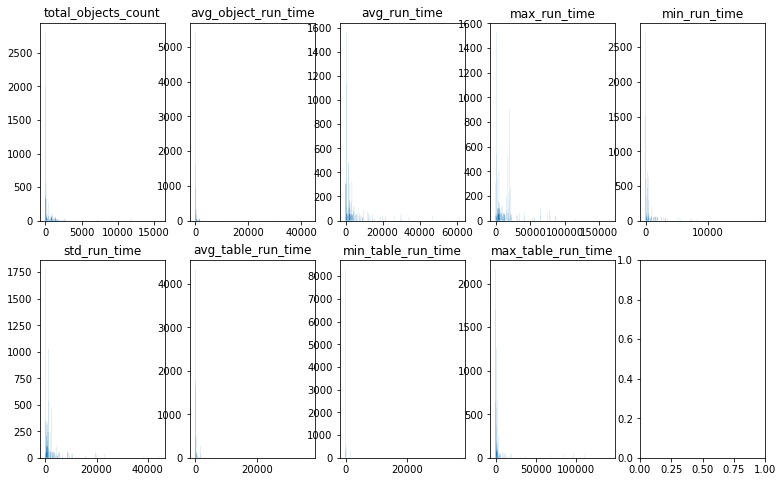

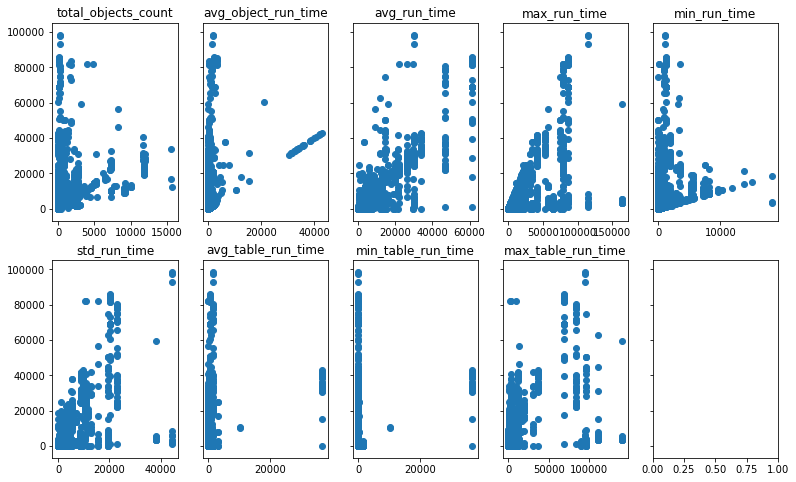

In [15]:
#Redo visualization with clean data
for name, group in clean_data.groupby('jobType'):
    print name
    print group.describe()
    fig, axes = plt.subplots(nrows = 2, ncols = 5, sharey=False, figsize = (10,12))
    fig2, axes2 = plt.subplots(nrows = 2, ncols = 5, sharey=False, figsize = (13,8))
    fig3, axes3 = plt.subplots(nrows = 2, ncols = 5, sharey=True, figsize = (13,8))
    for i in range(len(num_features)):
        f = num_features[i]
        print f
        x = group[f]
        y = group[target]
        axes[i/5,i%5].boxplot(x.values, showmeans=True)
        axes[i/5,i%5].set_title(f)
        axes2[i/5,i%5].hist(x.values, bins=1000, histtype='stepfilled')
        axes2[i/5,i%5].set_title(f)
        axes3[i/5,i%5].scatter(x.values, y)
        axes3[i/5,i%5].set_title(f)
    plt.show()

## MODEL SELECTION

This is a regression problem, so I'm going to explore some of the common regression algorithms below.  Beginning with a benchmarking model and then going through some others.  My initial thoughts lean toward decision trees or an ensemble method, but I will use the exploratory part to get some preliminary results before picking a model to tune.

## PRE-PROCESS DATA

In [16]:
#Separating feature and target datasets
feature_data = clean_data[features]
target_data = clean_data[target]

#one-hot-encoding categorical features
feature_data = pd.get_dummies(feature_data, columns=cat_features)


## PREPARE TRAINING DATA

In [17]:
from sklearn.model_selection import train_test_split

# create train and test data with 80% split
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, train_size = .8, random_state = 42)

print(X_train.shape)

(17391, 138)


## BENCHMARKING

Using a simple target to benchmark for the models we are going to create.  

The simple target is created by the following formula (total_objects * avg_table_run_time)

29


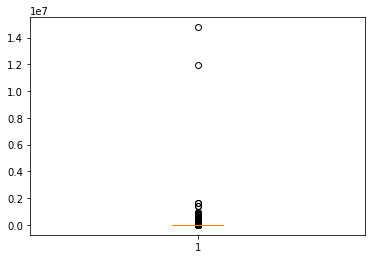

In [18]:
#Add simple target

simple_target = clean_data.total_objects_count * clean_data.avg_object_run_time 

plt.boxplot(simple_target)

#There are three huge numbers here, going to cut those down and make them 3+ std

#Finding outliers
outliers_simp = simple_target[np.abs(simple_target -simple_target.mean()) > 3* simple_target.std()].index.tolist()

print len(outliers_simp)

In [19]:
#Setting those two the max actual run time for any job
simple_target[outliers_simp] = max(clean_data.run_time)

{'boxes': [<matplotlib.lines.Line2D at 0xe366550>],
 'caps': [<matplotlib.lines.Line2D at 0x1069df28>,
 'fliers': [<matplotlib.lines.Line2D at 0x10b1f0b8>],
 'means': [<matplotlib.lines.Line2D at 0xd686470>],
 'medians': [<matplotlib.lines.Line2D at 0xd686630>],
 'whiskers': [<matplotlib.lines.Line2D at 0xe3666d8>,
  <matplotlib.lines.Line2D at 0x1069dc18>]}

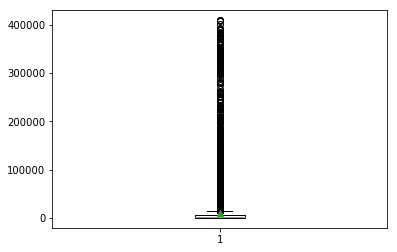

In [20]:
plt.boxplot(simple_target, showmeans=True)

Benchmark R2-Score: -26.6180088569
Benchamrk Standard Error:27859.3835965


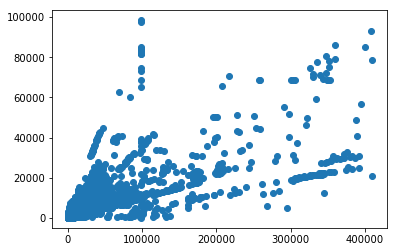

In [21]:
from sklearn.metrics import r2_score

r2_simple = r2_score(clean_data.run_time, simple_target)
se = st_err(clean_data.run_time, simple_target)

print("Benchmark R2-Score: " + str(r2_simple))
print("Benchamrk Standard Error:" + str(se))

plt.scatter(simple_target, clean_data[target])


## MODEL DATA

Going to try out some algorithms to see what basic implementations with no tuning produce.  After that will narrow down to one algorithm and do some parameter fine tuning.

#### LINEAR REGRESSION

In [22]:
from sklearn.linear_model import LinearRegression

# Most basic linear regression
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
r2_lm = r2_score(y_pred, y_test)
print("Basic LR R2-Score: " + str(r2_lm))

Basic LR R2-Score: 0.565938910277


In [23]:
coef = zip(features, lm.coef_)
print coef

[('source', array([  7.00149506e-01,   9.72217905e-01,   9.67734804e-01,
        -1.03650730e-02,  -1.25964884e-01,  -8.94439598e-02,
         3.62110477e-02,  -8.80153762e-01,   8.58035920e-03,
        -1.71586651e+02,   1.18257992e+02,  -1.86928964e+01,
         2.59346064e+02,   2.25112426e+02,   9.53334533e+02,
         6.76243744e+01,   2.53492829e+02,   1.29749667e+02,
         1.49110430e+02,  -4.07383859e+02,   4.19532866e+01,
        -8.72327735e+00,   7.79150969e+02,   1.72988991e+02,
         2.72866603e+02,   6.53440921e+02,   1.45824235e+02,
         5.33493000e+02,   3.01152664e+02,  -4.50377734e+03,
         1.39697908e+02,   2.14050158e+02,   1.24339700e+03,
         2.36768758e+02,  -1.90402422e+01,   6.32217588e+01,
         8.74611004e+01,  -1.15750704e+03,  -1.26150843e+02,
        -2.43749250e+02,  -1.06998057e+02,   1.43695239e+02,
        -2.04461704e+02,   6.96784316e+00,   7.76464708e+01,
        -4.13323840e+01,   7.84098315e+00,  -9.99247789e+01,
         1.6

#### DECISION TREE

Going to start with a basic decision tree without any parameter tuning or going to an ensemble method for comparsion

In [24]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

# Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train, y_train['run_time'])


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [25]:
y_pred = dtr.predict(X_test)

r2 = r2_score(y_test['run_time'], y_pred)
print("Basic R2-Score from Decision Tree: " + str(r2))

#Print Feature importance
print pd.DataFrame(sorted(zip(X_train.columns, dtr.feature_importances_), key=lambda x: x[1], reverse=True))

Basic R2-Score from Decision Tree: 0.865513224001
                                  0             1
0                      avg_run_time  7.242072e-01
1               avg_object_run_time  1.245547e-01
2               total_objects_count  8.549245e-02
3                      std_run_time  3.014667e-02
4                      max_run_time  1.683126e-02
5                  source_JCH Spain  6.647353e-03
6                      min_run_time  2.948170e-03
7                min_table_run_time  2.403528e-03
8                     source_Maximo  1.677791e-03
9                  dbType_sqlserver  1.605149e-03
10               avg_table_run_time  1.056336e-03
11               max_table_run_time  9.350323e-04
12              source_JCH Thailand  5.866953e-04
13          source_Service Alliance  2.784154e-04
14                     source_Avaya  1.510247e-04
15                   dbType_Web API  8.927582e-05
16             source_Macpac Ruskin  6.292111e-05
17   source_MfgPro PS North America  5.762361e-05


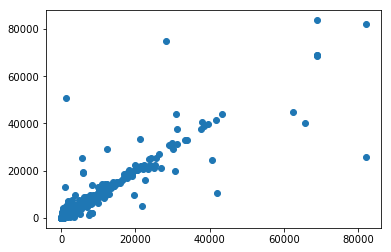

In [26]:
plt.scatter(y_test, y_pred)

#### RANDOM FOREST REGRESSOR

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Basic Random Forest R2: 0.916415097106
                  0
count   4348.000000
mean      14.968175
std     1374.739751
min   -31851.400000
25%       -9.140000
50%        0.361667
75%       15.116667
max    40022.700000


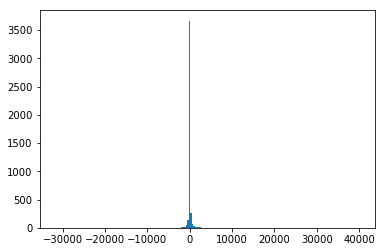

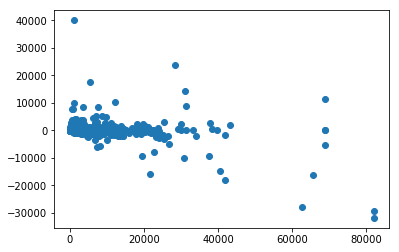

In [27]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = pd.DataFrame(rf.predict(X_test))

r2_rf = r2_score(y_test, y_pred)

print "Basic Random Forest R2: " + str(r2_rf)
errors = pd.DataFrame([np.subtract(x1,x2) for x1,x2 in zip(y_pred[0].tolist(), y_test.run_time.tolist())])

print errors.describe()

plt.hist(errors[0], bins=200)
plt.show()
plt.scatter(y_test, errors[0])
plt.show()

In [28]:
#Print estimators
print rf.estimators_
#Print Feature importance
print pd.DataFrame(sorted(zip(X_train.columns, dtr.feature_importances_), key=lambda x: x[1], reverse=True))

[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False,
           random_state=1608637542, splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False,
           random_state=1273642419, splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False,
           random_state=1935803228, splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min

#### GRADIENT BOOSTING REGRESSOR

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=39, max_depth=10)
gbr.fit(X_train, y_train)

y_pred = pd.DataFrame(gbr.predict(X_test))

r2_gbr = r2_score(y_test, y_pred)

print "Basic R2 from Gradient Boosting: " + str(r2_gbr)


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Basic R2 from Gradient Boosting: 0.877349000195


#### ADA BOOST

In [30]:
from sklearn.ensemble import AdaBoostRegressor

abr = AdaBoostRegressor(dtr, n_estimators=300, random_state = 42)
abr.fit(X_train, y_train)

y_pred = pd.DataFrame(abr.predict(X_test))

r2_abr = r2_score(y_test, y_pred)

print "Basic R2 from Ada Boost: " + str(r2_abr)

Basic R2 from Ada Boost: 0.846061878902


#### SUPPORT VECTOR

In [32]:
#Scaling data for the Support Vector and MLP algorithms which are sensitive to different ranges

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train_scale = scaler.transform(X_train)  

# apply same transformation to test data
X_test_scale = scaler.transform(X_test) 



In [48]:
from sklearn import svm

svr = svm.SVR()

svr.fit(X_train_scale, y_train) 

y_pred = svr.predict(X_test_scale)

r2_svr = r2_score(y_test, y_pred)

print "Basic R2 from SVR: " + str(r2_svr)

Basic R2 from SVR: -0.0421637166803


#### MULTI LAYER PERCEPTRON

In [33]:
mlp = MLPRegressor(random_state = 42, max_iter=1000)

mlp.fit(X_train_scale, y_train)

y_pred = mlp.predict(X_test_scale)

r2_mlp = r2_score(y_test, y_pred)

print "R2 Score from Basic MLP: " + str(r2_mlp)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 Score from Basic MLP: 0.738038634179


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


### PRELIMINARY NOTES
The results of the tests above lead me to believe a random forest may be the most accurate. In looking at the feature importances from my basic decision tree, there are a lot of features that aren't adding a lot to the model. I am going to try removing some of those features and rerunning.  I am also going to try to run with separate models per job type to see how those perform before I go into in-depth tuning.

In [34]:
features = ['total_objects_count', 'avg_run_time', 'avg_object_run_time', 'std_run_time', 'min_run_time', 'max_run_time']
cat_features = []

#After running with all available features above, selecting just the ones that relatively high feature importance
#('avg_run_time', 0.6745514823087555), ('avg_object_run_time', 0.16317247183285116), ('total_objects_count', 0.12010544013616073), ('std_run_time', 0.011227497339690929), ('min_run_time', 0.0076543870411003708), ('max_run_time', 0.0075402719639399663), ('max_table_run_time', 0.0049852210396902387)

In [35]:
#Separating new features
feature_data = clean_data[features]

#No one-hot encoding needed because all numeric features
if len(cat_features) > 0:
    feature_data = pd.get_dummies(feature_data, columns=cat_features)
print feature_data.shape

(21739, 6)


In [36]:
#adding in datasets by job type as I'm wondering if I made three models it might be more effective than a single
#model to predict all the types
featureDict = {}
targetDict = {}
for item in clean_data['jobType'].unique():
    featureDict[item] = clean_data[features][clean_data.jobType==item]
    targetDict[item] = clean_data[target][clean_data.jobType==item]
    if len(cat_features) > 0:
        featureDict[item] = pd.get_dummies(featureDict[item], columns=cat_features)

In [37]:
#Breaking up test and training data for items in dictionary
ttDict = {}

for item in clean_data['jobType'].unique():
    ttDict[item] = train_test_split(featureDict[item], targetDict[item], train_size = .8, random_state = 42)
    

Random Forests R2 by job type: raw 0.891490590678
Random Forests R2 by job type: hive 0.952891276412
Random Forests R2 by job type: cdc 0.739457684564
{'raw': array([ 0.0891075 ,  0.71350407,  0.12302613,  0.0338178 ,  0.00779032,
        0.03275417]), 'hive': array([ 0.31347985,  0.21833248,  0.42406836,  0.00399985,  0.02096109,
        0.01915838]), 'cdc': array([ 0.15041135,  0.03444218,  0.72633968,  0.05644482,  0.01197086,
        0.02039112])}
raw


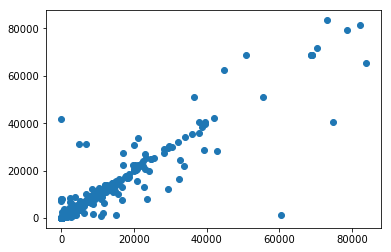

hive


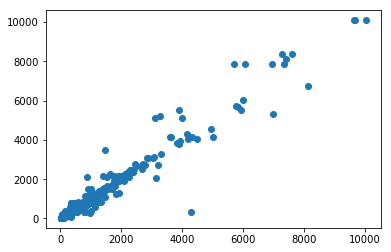

cdc


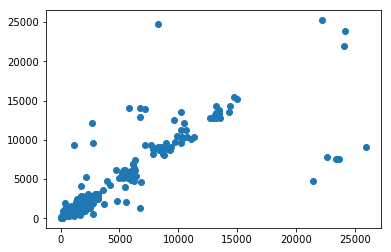

In [38]:
# Decision Tree Regressor
dtr = DecisionTreeRegressor(max_depth=12)
dtr.fit(X_train, y_train['run_time'])

rfDict = {}
rfPreds = {}
r2Scores = {}
featImp = {}

for item in clean_data['jobType'].unique():
    rfDict[item] = DecisionTreeRegressor(random_state = 42)
    rfDict[item].fit(ttDict[item][0], ttDict[item][2])
    rfPreds[item] = rfDict[item].predict(ttDict[item][1])
    r2Scores[item] = r2_score(ttDict[item][3],rfPreds[item])
    featImp[item] = rfDict[item].feature_importances_

for z,y in r2Scores.iteritems():
    print "Random Forests R2 by job type: " + z,y

print featImp
    
for item in clean_data['jobType'].unique():
    print item
    plt.scatter(ttDict[item][3], rfPreds[item], label=item)
    plt.show()

### MODEL SELECTION

Based on the results above, I am going to do more optimzation with a random forest regressor.

Also, I am not going to split the data on job type as the gains weren't enough for me to justify the increased overhead when I productionalize the code of maintaing three models and choose the correct one at run time.

In [106]:
#Resplit data with new feature set

# create train and test data with 80% split
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, train_size = .8, random_state = 42)

print(X_train.shape)

(17391, 6)


### MODEL OPTIMIZATION

In [107]:
# Baseline before optimization with new smaller feature set
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = pd.DataFrame(rf.predict(X_test))

r2_rf = r2_score(y_test, y_pred)

print "Basic Random Forest R2: " + str(r2_rf)
print rf.estimators_

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


Basic Random Forest R2: 0.907566993692
[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False,
           random_state=1608637542, splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False,
           random_state=1273642419, splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False,
           random_state=1935803228, splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='aut

In [108]:
from sklearn.model_selection import GridSearchCV

param_grid = {
                 #'n_estimators': [10] #[50, 70, 90], #[25, 35, 50], #[20, 25, 35, 50], #[13, 14, 15], #[10, 15, 20] #70 best
                 #'max_depth': [13, 15, 19], #[15, 16, 17], #[15, 17, 19], None best
                 'max_features': ['auto', 'sqrt', 'log2'], #['auto', 'sqrt'] auto best
                 #'min_samples_leaf': [1, 10], #default of 1 was best
                 #'criterion': ['mse', 'mae'],
                 'oob_score': ['True'] #['True', 'False'] True best
             }

rfGS = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=8)
rfGS.fit(X_train, y_train)
y_pred = rfGS.predict(X_test)

rfGS_r2 = r2_score(y_test, y_pred)


Optimized Forest R2: 0.89729626162
Optimized Forest Standard Error: 1523.79131795


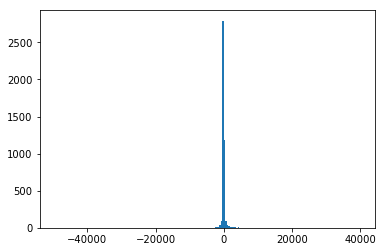

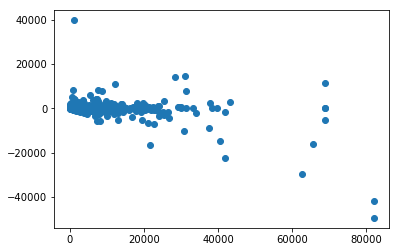

In [109]:
#Evaluation Metrics for Final Model 

print "Optimized Forest R2: " + str(rfGS_r2)
errors = pd.DataFrame([np.subtract(x1,x2) for x1,x2 in zip(y_pred, y_test.run_time.tolist())])
standard_error = st_err(y_test.run_time.tolist(), y_pred)
print "Optimized Forest Standard Error: " + str(standard_error) 

plt.hist(errors[0], bins=200)
plt.show()
plt.scatter(y_test, errors[0])
plt.show()

In [57]:
pd.DataFrame(rfGS.cv_results_).transpose().style

In [110]:
print rfGS.best_params_
print rfGS.best_estimator_

{'max_features': 'sqrt', 'oob_score': 'True'}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score='True', random_state=42,
           verbose=0, warm_start=False)


## FINAL VISUALIZATION

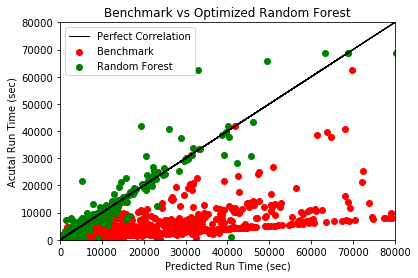

In [111]:
#Scatter Benchmark vs Final Solution

simple_target_test = X_test.total_objects_count * X_test.avg_object_run_time

plt.axis([0,80000,0,80000])
plt.scatter(simple_target_test, y_test, c="red",label="Benchmark")
plt.scatter(y_pred, y_test, c="green", label="Random Forest")
plt.plot(y_test, y_test, c="black", label="Perfect Correlation", linewidth=1.0)
plt.title("Benchmark vs Optimized Random Forest")
plt.xlabel("Predicted Run Time (sec)")
plt.ylabel("Acutal Run Time (sec)")
plt.legend()
plt.show()


In [114]:
#Look at some outliers that fall near the bottom of the y-axis
dat1 = X_test.reset_index(drop=True)
dat2 = pd.DataFrame(y_pred, columns=['pred']).reset_index(drop=True)
dat3 = y_test.reset_index(drop=True)
results = pd.concat([dat1,dat2, dat3], axis=1)
print results[results.pred>40000]

#outlier
print results.iloc[1692]

print X_test[y_test.run_time==1176]
print y_pred[y_pred==40896.3]

y_test_cln = y_test[y_test.run_time != 1176]
y_pred_cln = y_pred[y_pred!=40896.3]

rfGS_r2_cln = r2_score(y_test_cln, y_pred_cln)
print "R2 Score without outlier: " + str(rfGS_r2_cln)


      total_objects_count  avg_run_time  avg_object_run_time  std_run_time  \
563                   276  46758.000000             753.5109  23145.667207   
879                  3956  21758.540540             409.4616  10304.577746   
1080                  175  61347.523810            1750.4514  20133.590692   
1692                    1  61347.523810            1173.0000  20133.590692   
1916                  175  61347.523810            1729.0114  20133.590692   
3212                  860  14504.211538             265.2553  19663.840412   
3298                 1640  14504.211538             170.2207  19663.840412   
3529                  839  29904.566038             137.3933   9124.242816   
3587                  175  61347.523810            1471.1657  20133.590692   
3678                  839  29904.566038              77.1492   9124.242816   
3698                  926  14504.211538             304.2091  19663.840412   
3840                  175  61347.523810            2746.3829  20